In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import spacy
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
import numpy as np
from datasets import load_dataset
import warnings
import torch
import os
import json


gpu_index = 2
device = torch.device(f'cuda:{gpu_index}' if torch.cuda.is_available() else 'cpu')
device

warnings.filterwarnings('ignore')

In [2]:
# Load dataset from Hugging Face
dataset = load_dataset("nixbel/dataset_train_thesis", split="train")

df = pd.DataFrame(dataset)

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12821 entries, 0 to 12820
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  12821 non-null  object
 1   Authors   12821 non-null  object
 2   Date      12821 non-null  object
 3   Content   12821 non-null  object
 4   Brand     12821 non-null  object
 5   URL       12821 non-null  object
 6   Label     12821 non-null  object
dtypes: object(7)
memory usage: 701.3+ KB
None
                                                 Headline        Authors  \
count                                               12821          12821   
unique                                              11685            507   
top     Results, team standings: UAAP Season 86 volley...  ['Pol Pinoy']   
freq                                                   31           4012   

                    Date                                            Content  \
count              12821                   

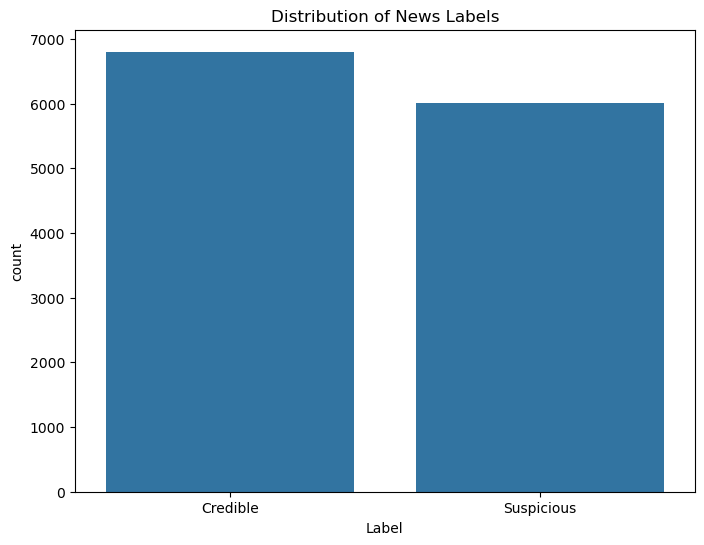

In [3]:
# Label Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Label')
plt.title('Distribution of News Labels')
plt.show()

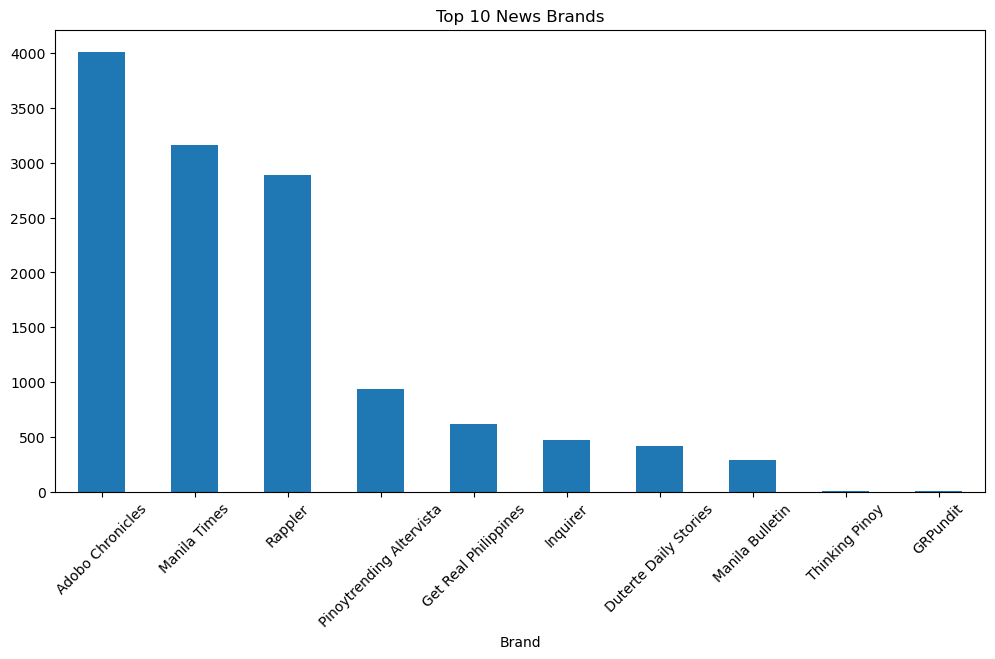

In [4]:
# Brand and Author Analysis
plt.figure(figsize=(12, 6))
df['Brand'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 News Brands')
plt.xticks(rotation=45)
plt.show()

In [5]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags if present
    text = re.sub(r'<.*?>', '', text)
    # Replace multiple spaces with a single space
    text = ' '.join(text.split())
    return text

In [6]:
# Apply cleaning to content column
df['cleaned_content'] = df['Content'].apply(clean_text)

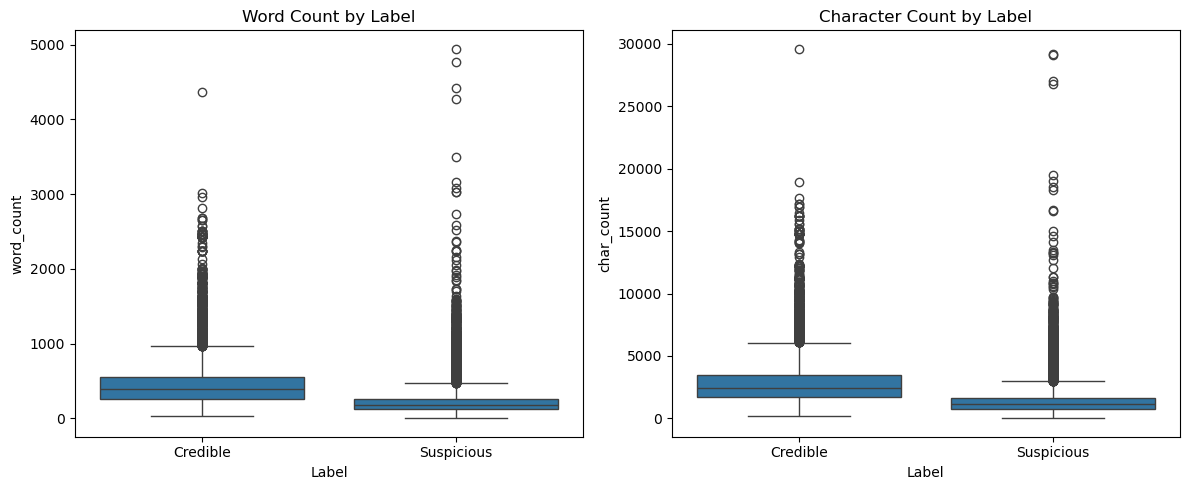

In [7]:
# Text Statistics
df['word_count'] = df['cleaned_content'].str.split().str.len()
df['char_count'] = df['cleaned_content'].str.len()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Label', y='word_count')
plt.title('Word Count by Label')
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Label', y='char_count')
plt.title('Character Count by Label')
plt.tight_layout()
plt.show()

In [8]:
# Common Words and N-grams
def get_ngrams(text, n):
    tokens = word_tokenize(text)
    return list(ngrams(tokens, n))

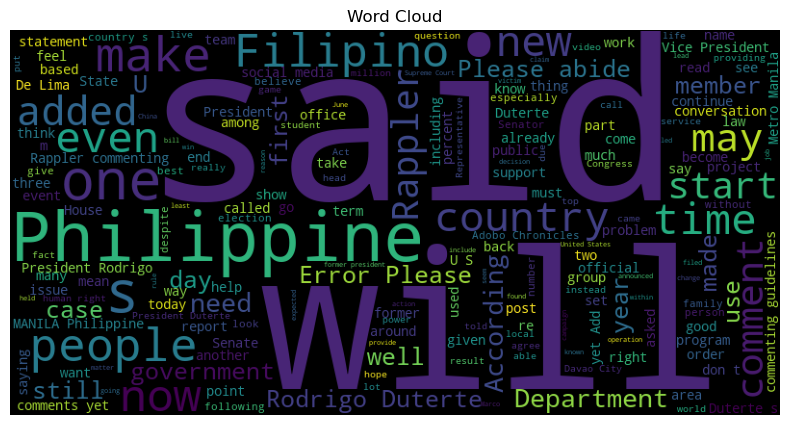

In [9]:
# Word cloud
text = ' '.join(df['cleaned_content'])
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud')
plt.show()

In [10]:
# Named Entity Recognition
nlp = spacy.load('en_core_web_sm')
def get_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

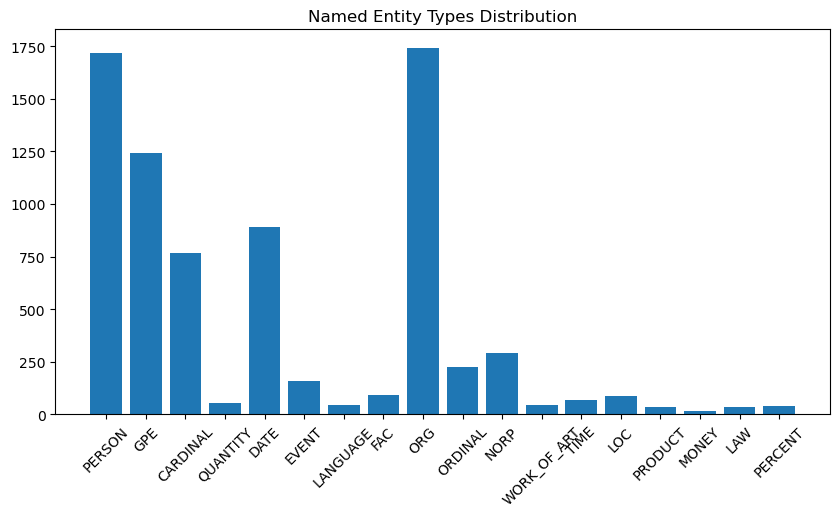

In [11]:
# Sample NER analysis on a subset
sample_ner = df['Content'].head(100).apply(get_entities)
ner_counts = Counter([ent[1] for ents in sample_ner for ent in ents])

plt.figure(figsize=(10, 5))
plt.bar(ner_counts.keys(), ner_counts.values())
plt.xticks(rotation=45)
plt.title('Named Entity Types Distribution')
plt.show()

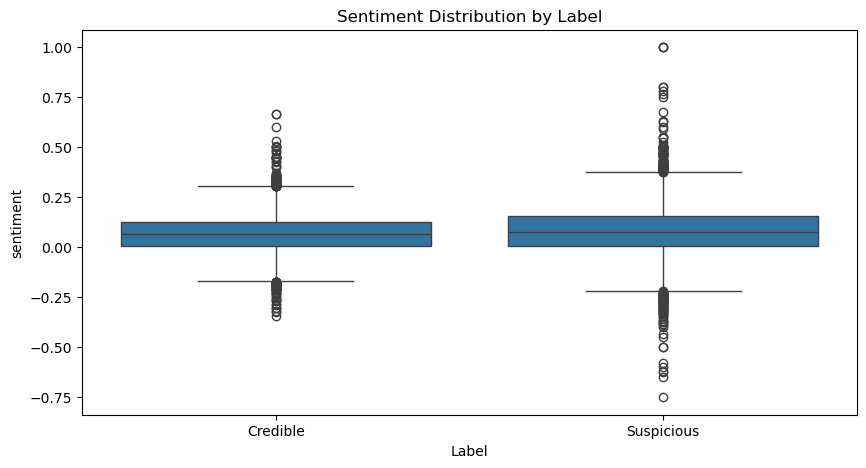

In [12]:
# Sentiment Analysis
df['sentiment'] = df['Content'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Label', y='sentiment')
plt.title('Sentiment Distribution by Label')
plt.show()

In [13]:
#Topic Modeling (LDA)
# Convert TFIDF matrix to gensim format
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['cleaned_content'])

# Convert to gensim corpus format
corpus = []
for i in range(tfidf_matrix.shape[0]):
    # Get the non-zero elements in each row
    row = tfidf_matrix[i].tocoo()
    # Add as (word_id, weight) tuples
    document = [(int(word_id), float(weight)) for word_id, weight in zip(row.col, row.data)]
    corpus.append(document)

# Create dictionary
dictionary = {i: word for word, i in vectorizer.vocabulary_.items()}

# Train LDA model
lda = models.LdaModel(
    corpus=corpus,
    num_topics=5,
    id2word=dictionary
)

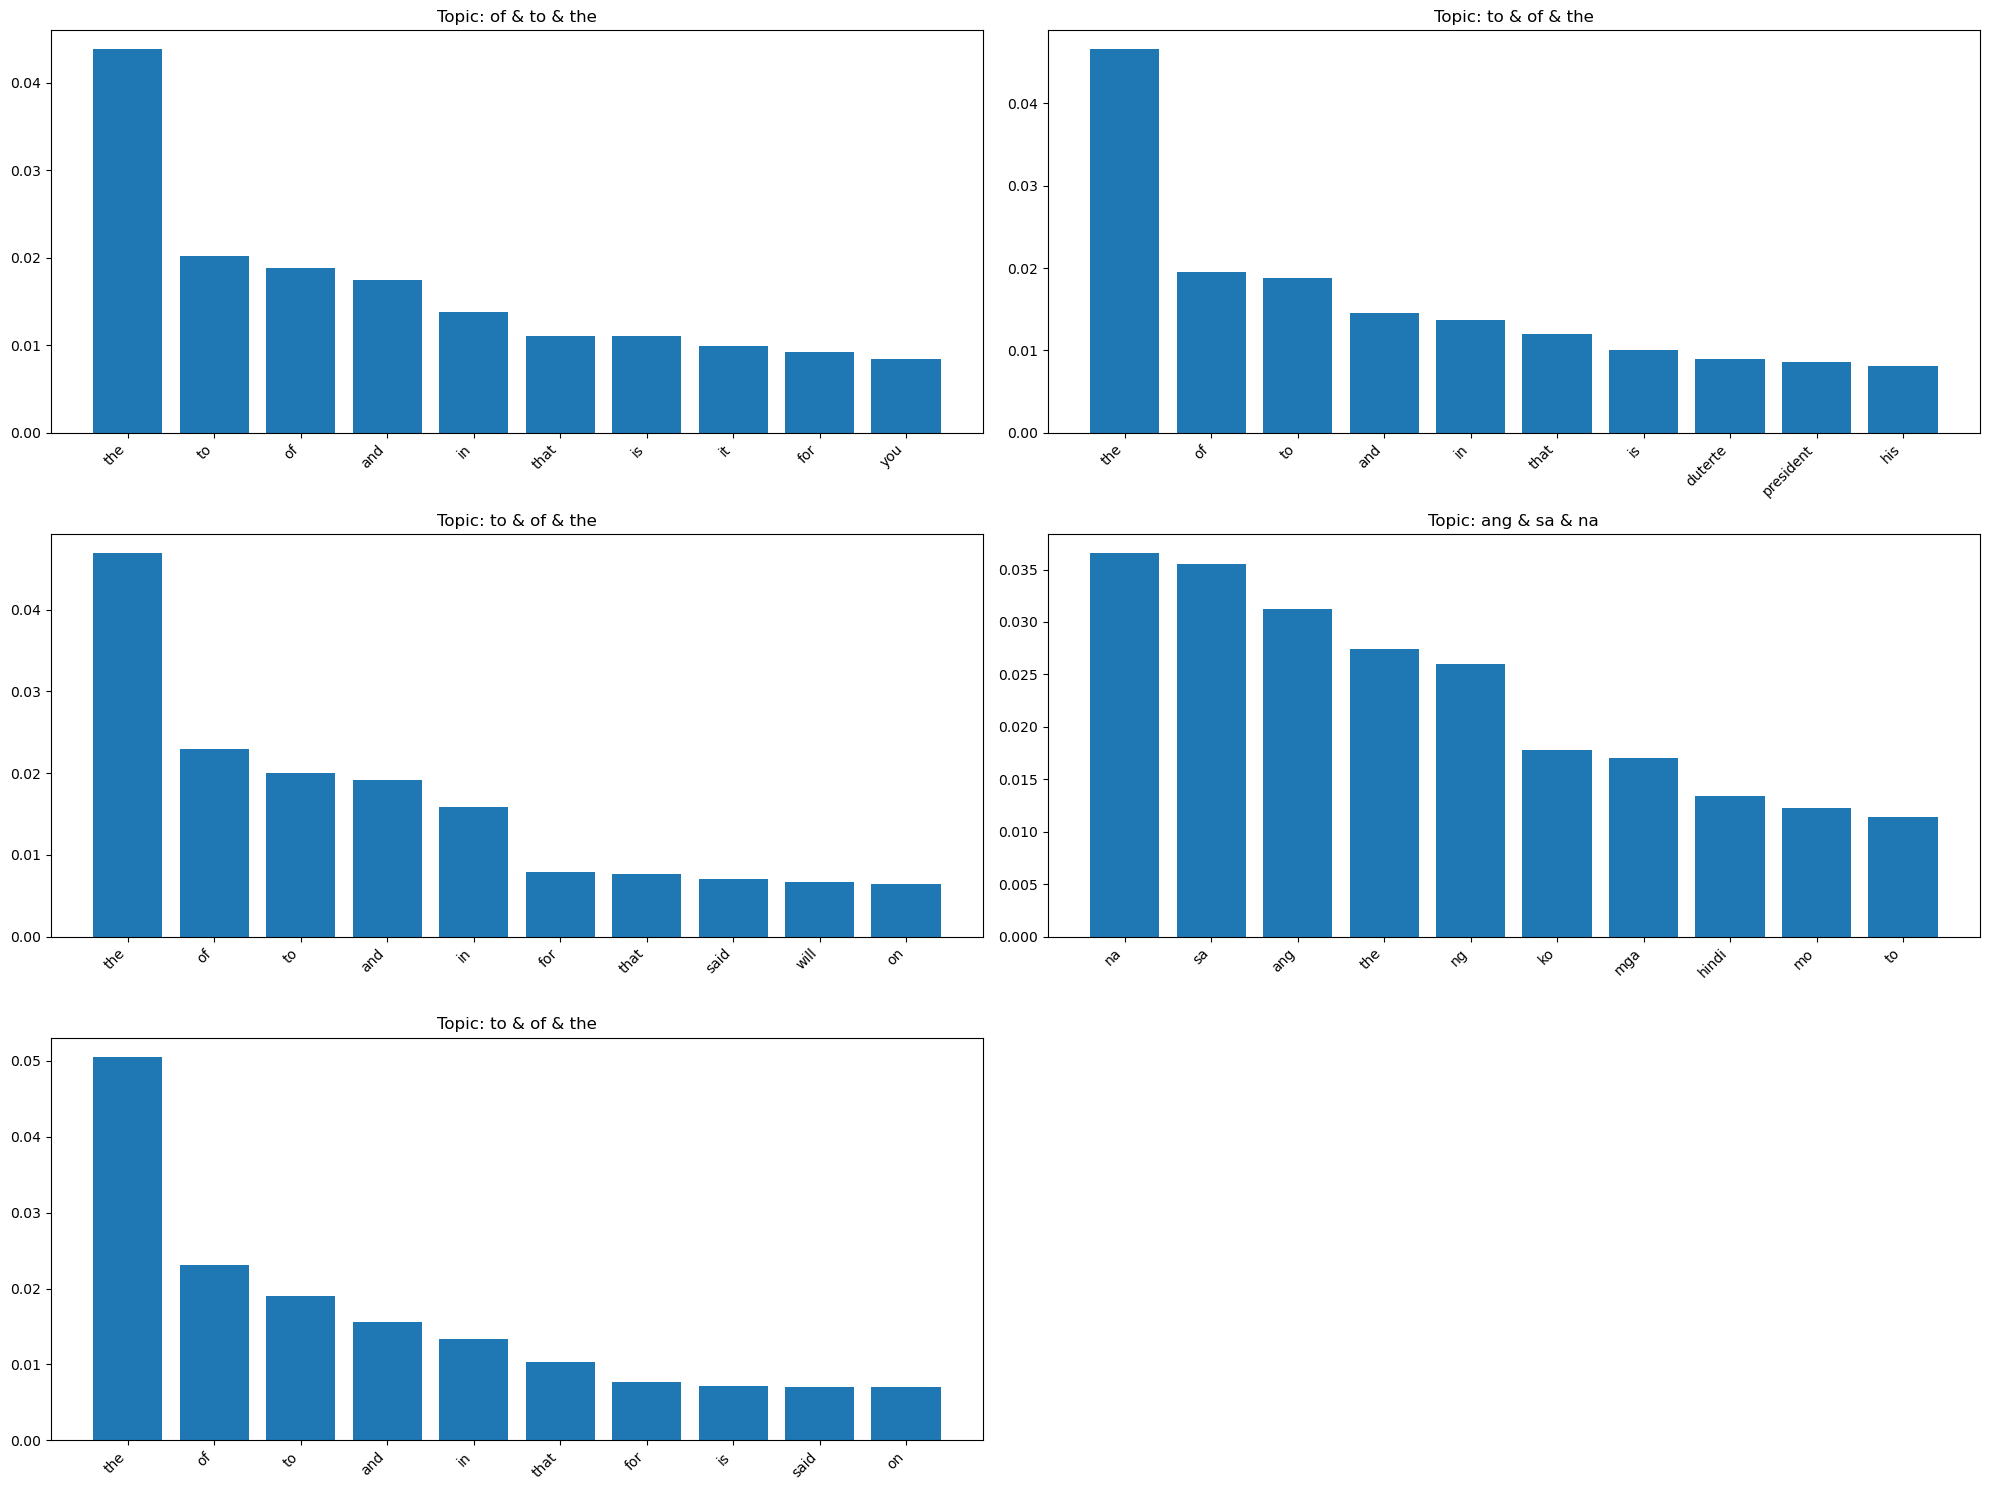

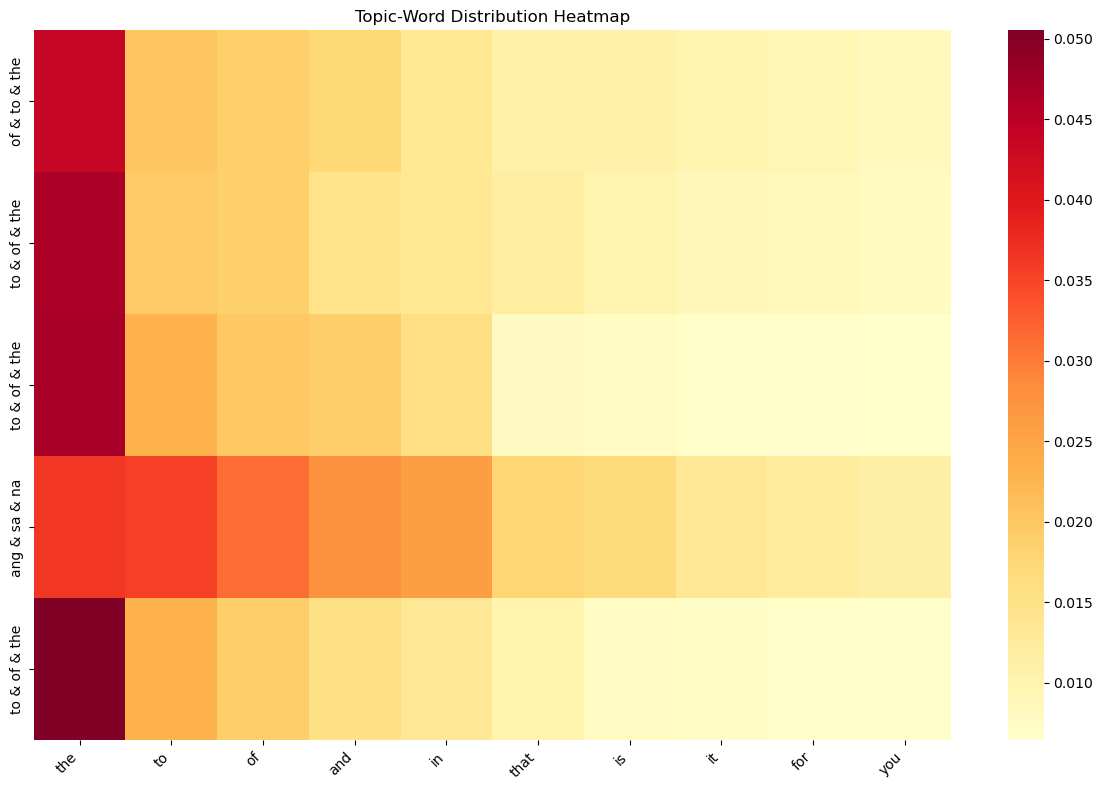

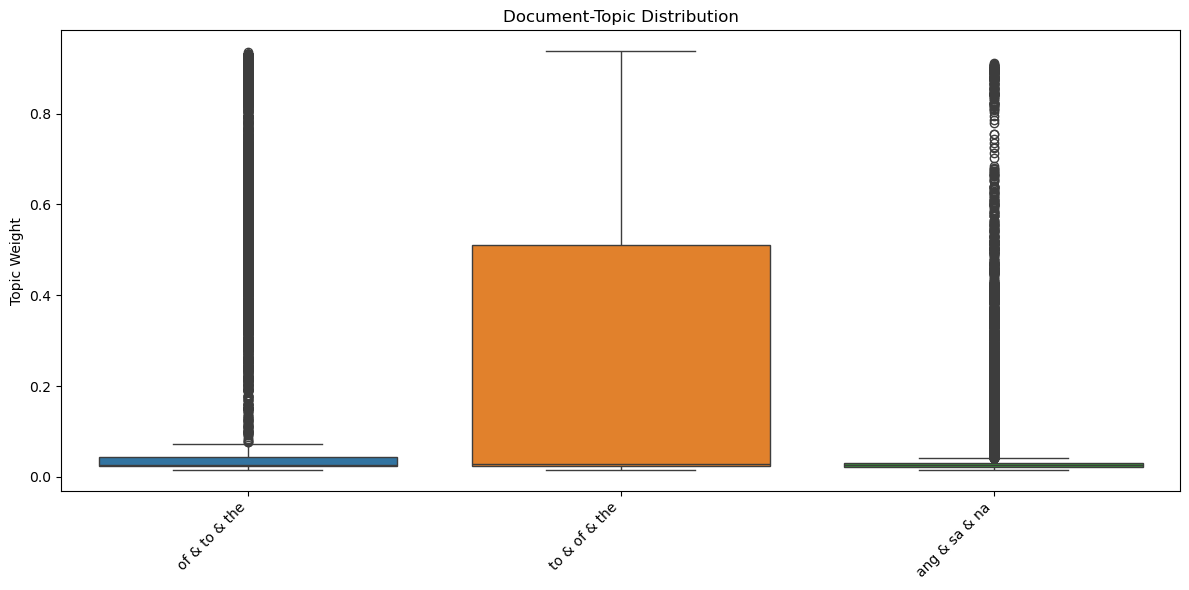


Topic Interpretations:
Topic 1: of & to & the
Top words: the, to, of, and, in

Topic 2: to & of & the
Top words: the, of, to, and, in

Topic 3: to & of & the
Top words: the, of, to, and, in

Topic 4: ang & sa & na
Top words: na, sa, ang, the, ng

Topic 5: to & of & the
Top words: the, of, to, and, in



In [15]:
# Interpret and assign topic labels based on the most common words
def assign_topic_label(words, weights):
    # You can customize these interpretations based on your domain knowledge
    # This is a simple example that uses the top 3 words to create a label
    top_words = [words[i] for i in np.argsort(weights)[-3:]]
    return ' & '.join(top_words)

# Get topic words and their weights
topic_words = []
topic_weights = []
topic_labels = []
for idx, topic in lda.show_topics(formatted=False, num_words=10):
    words = [w[0] for w in topic]
    weights = [w[1] for w in topic]
    topic_words.append(words)
    topic_weights.append(weights)
    topic_labels.append(assign_topic_label(words, weights))

# Create visualizations for each topic
plt.figure(figsize=(20, 15))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.bar(topic_words[i], topic_weights[i])
    plt.title(f'Topic: {topic_labels[i]}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create heatmap of topic-word distributions
topic_word_matrix = np.zeros((5, 10))
for i in range(5):
    topic_word_matrix[i] = topic_weights[i]

plt.figure(figsize=(12, 8))
sns.heatmap(
    topic_word_matrix, 
    xticklabels=topic_words[0],
    yticklabels=topic_labels,  # Using interpreted topic labels
    cmap='YlOrRd'
)
plt.title('Topic-Word Distribution Heatmap')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Document-Topic Distribution
doc_topics = [lda.get_document_topics(doc) for doc in corpus]
doc_topic_matrix = np.zeros((len(corpus), 5))
for i, doc in enumerate(doc_topics):
    for topic_id, weight in doc:
        doc_topic_matrix[i, topic_id] = weight

plt.figure(figsize=(12, 6))
sns.boxplot(data=pd.DataFrame(doc_topic_matrix, columns=topic_labels))  # Using interpreted topic labels
plt.title('Document-Topic Distribution')
plt.ylabel('Topic Weight')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print topic interpretations
print("\nTopic Interpretations:")
for i, label in enumerate(topic_labels):
    print(f"Topic {i+1}: {label}")
    print(f"Top words: {', '.join(topic_words[i][:5])}\n")

In [16]:
# Import required libraries
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, AdamW, PretrainedConfig, PreTrainedModel, AdamW
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report, matthews_corrcoef
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [17]:
from textblob import TextBlob

def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [18]:
import spacy
nlp = spacy.load("en_core_web_sm")

def count_named_entities(text):
    doc = nlp(text)
    return len(doc.ents)


In [19]:
from textstat import flesch_reading_ease

def calculate_readability(text):
    return flesch_reading_ease(text)


In [20]:
def clean_text_roberta(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags if present
    text = re.sub(r'<.*?>', '', text)
    # Replace multiple spaces with a single space
    text = ' '.join(text.split())
    return text

In [21]:

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def preprocess_data(df):
    """
    Preprocess the dataframe by cleaning text and adding necessary numerical features
    """
    try:
        # Clean text data
        df['Clean_Content'] = df['Content'].apply(clean_text_roberta)
        df['Clean_Headline'] = df['Headline'].apply(clean_text_roberta)
        
        # Calculate content length using cleaned text
        df['content_length'] = df['Clean_Content'].str.len()
        
        # Calculate headline length using cleaned text
        df['headline_length'] = df['Clean_Headline'].str.len()
        
        # Calculate number of authors (assuming authors are separated by commas)
        df['author_count'] = df['Authors'].str.count(',') + 1

        df['sentiment_score'] = df['Clean_Content'].apply(calculate_sentiment)
        df['entity_count'] = df['Clean_Content'].apply(count_named_entities)
        df['readability_score'] = df['Clean_Content'].apply(calculate_readability)
        
        # Normalize numerical features
        numerical_columns = ['content_length', 'headline_length', 'author_count', 
                            'sentiment_score', 'entity_count', 'readability_score']
        for col in numerical_columns:
            mean = df[col].mean()
            std = df[col].std()
            df[col] = (df[col] - mean) / std
        
        return df
    except Exception as e:
            print(f"Error in preprocessing: {str(e)}")
            raise

# Custom Dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, headlines, numerical_features, labels, tokenizer, max_length=512):
        self.texts = texts
        self.headlines = headlines
        self.numerical_features = numerical_features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        try:
            text = str(self.texts[idx])
            headline = str(self.headlines[idx])
            
            # Combine headline and content
            combined_text = headline + " </s> " + text
            
            encoding = self.tokenizer.encode_plus(
                combined_text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )

            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'numerical_features': torch.tensor(self.numerical_features[idx], dtype=torch.float),
                'labels': torch.tensor([self.labels[idx]], dtype=torch.float)
            }
        except Exception as e:
                print(f"Error in dataset __getitem__: {str(e)}")
                raise

# Custom config class
class NewsClassifierConfig(PretrainedConfig):
    model_type = "news_classifier"
    
    def __init__(
        self,
        n_numerical_features=6,
        numerical_mean=None,
        numerical_std=None,
        numerical_features=None,
        **kwargs
    ):
        self.n_numerical_features = n_numerical_features
        self.numerical_mean = numerical_mean if numerical_mean is not None else [0.0]*n_numerical_features
        self.numerical_std = numerical_std if numerical_std is not None else [1.0]*n_numerical_features
        self.numerical_features = numerical_features if numerical_features is not None else []
        super().__init__(**kwargs)
    
# Model definition
class NewsClassifier(PreTrainedModel):
    config_class = NewsClassifierConfig

    def __init__(self, config):
        super().__init__(config)
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.numerical_layer = torch.nn.Linear(config.n_numerical_features, 32)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(self.roberta.config.hidden_size + 32, 1)

        # Initialize normalization parameters from config
        self.register_buffer("numerical_mean", torch.tensor(config.numerical_mean))
        self.register_buffer("numerical_std", torch.tensor(config.numerical_std))
        
    def forward(self, input_ids, attention_mask, numerical_features):
        # Normalize numerical features using parameters from config
        normalized_features = (numerical_features - self.numerical_mean) / self.numerical_std

        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0][:, 0, :]  # CLS token
        numerical_output = self.numerical_layer(normalized_features)
        combined = torch.cat((pooled_output, numerical_output), dim=1)
        output = self.dropout(combined)
        return self.classifier(output)
    
    
def save_model_for_inference(model, tokenizer, df, output_dir):
    try:
        os.makedirs(output_dir, exist_ok=True)
        # Define numerical columns
        numerical_columns = ['content_length', 'headline_length', 'author_count', 
                            'sentiment_score', 'entity_count', 'readability_score']
        
        # Calculate means and stds from training data
        means = df[numerical_columns].mean().tolist()
        stds = df[numerical_columns].std().tolist()

        # Validate statistics
        if any(np.isnan(means)) or any(np.isnan(stds)):
            raise ValueError("Invalid normalization statistics detected")
        
        # Update model's normalization parameters in the config
        config = model.config
        config.numerical_mean = means
        config.numerical_std = stds
        config.numerical_features = numerical_columns

        # Update buffers directly
        model.numerical_mean = torch.tensor(means, dtype=torch.float32)
        model.numerical_std = torch.tensor(stds, dtype=torch.float32)
        
        # Save the model and tokenizer with safe serialization (safetensors)
        model.save_pretrained(output_dir, safe_serialization=True)
        tokenizer.save_pretrained(output_dir)
        print(f"Model and tokenizer saved with safetensors at {output_dir}")

        # Additionally, save the model in PyTorch's state_dict format (pytorch_model.bin)
        pytorch_model_path = os.path.join(output_dir, "pytorch_model.bin")
        torch.save(model.state_dict(), pytorch_model_path)
        print(f"Model weights saved as pytorch_model.bin at {pytorch_model_path}")

        return means, stds

    except Exception as e:
            print(f"Error saving model: {str(e)}")
            raise

def validate_numerical_features(features):
    if torch.any(torch.isnan(features)) or torch.any(torch.isinf(features)):
        raise ValueError("Invalid numerical features detected")
    return features


# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, df, n_epochs, max_grad_norm=1.0, output_dir="./model_for_hub", patience=2):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    early_stopping_counter = 0
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

    print(type(optimizer))

    try:    
        torch.cuda.empty_cache()  # Clear GPU memory before training

        for epoch in range(n_epochs):
            # Training
            model.train()
            total_train_loss = 0
            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
            
            for batch in progress_bar:
                optimizer.zero_grad()
                
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                numerical_features = batch['numerical_features'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask, numerical_features)
                loss = criterion(outputs, labels)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()
                
                total_train_loss += loss.item()
                progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})
            
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation
            model.eval()
            total_val_loss = 0
            
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    numerical_features = batch['numerical_features'].to(device)
                    labels = batch['labels'].to(device)
                    
                    outputs = model(input_ids, attention_mask, numerical_features)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
            
            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            print(f'Epoch {epoch+1}:')
            print(f'Average training loss: {avg_train_loss:.3f}')
            print(f'Average validation loss: {avg_val_loss:.3f}')
            
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                early_stopping_counter = 0

                model.save_pretrained(output_dir, safe_serialization=True)
                tokenizer.save_pretrained(output_dir)  # Save tokenizer

                print(f"Best model weights and normalization stats saved at {output_dir}")

                # Clear some memory
                if hasattr(torch.cuda, 'empty_cache'):
                    torch.cuda.empty_cache()

            else:
                early_stopping_counter += 1
                print(f"Early stopping counter: {early_stopping_counter}/{patience}")
                
            if early_stopping_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break
        
        return train_losses, val_losses
    except Exception as e:
        print(f"Error during training: {str(e)}")
        raise
    finally:
        torch.cuda.empty_cache()  # Clear GPU memory after training


def validate_saved_model_files(output_dir):
    #best_model_path = os.path.join(output_dir, "best_model")
    required_files = [
        'model.safetensors',
        'special_tokens_map.json',
        'tokenizer_config.json',
        'vocab.json',
        'merges.txt',
    ]

    missing_files = [f for f in required_files if not os.path.exists(os.path.join(output_dir, f))]

    if not missing_files:
        print("All required files have been successfully saved and are safe.")
    else:
        print(f"Warning: The following files are missing: {', '.join(missing_files)}")

def evaluate_model(model, test_loader):
    """
    Evaluate the model and return performance metrics
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_raw_predictions = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            numerical_features = batch['numerical_features'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask, numerical_features)
            predictions = (outputs >= 0.5).float()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_raw_predictions.extend(outputs.cpu().numpy())

    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_raw_predictions = np.array(all_raw_predictions)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Calculate ROC curve and ROC AUC
    fpr, tpr, _ = roc_curve(all_labels, all_raw_predictions)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_raw_predictions)
    pr_auc = auc(recall_curve, precision_curve)
    
    return (accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc, precision_curve, recall_curve, pr_auc, all_labels, all_predictions)



# Main execution
if __name__ == "__main__":
    # Preprocess data
    print("Preprocessing data...")
    df = preprocess_data(df)
    
     # Prepare numerical features
    numerical_columns = ['content_length', 'headline_length', 'author_count', 
                         'sentiment_score', 'entity_count', 'readability_score']
    numerical_features = df[numerical_columns].values
    labels = (df['Label'] == 'Suspicious').astype(int)
    
    # Split data
    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Label'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Label'], random_state=42)
    
    # Initialize tokenizer and create datasets
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    
    # Create datasets and dataloaders
    train_dataset = NewsDataset(
        train_df['Clean_Content'].values,
        train_df['Clean_Headline'].values,
        train_df[numerical_columns].values,
        (train_df['Label'] == 'Suspicious').astype(int).values,
        tokenizer
    )
    
    val_dataset = NewsDataset(
        val_df['Clean_Content'].values,
        val_df['Clean_Headline'].values,
        val_df[numerical_columns].values,
        (val_df['Label'] == 'Suspicious').astype(int).values,
        tokenizer
    )

    test_dataset = NewsDataset(
        test_df['Clean_Content'].values,
        test_df['Clean_Headline'].values,
        test_df[numerical_columns].values,
        (test_df['Label'] == 'Suspicious').astype(int).values,
        tokenizer
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)
    
    # Initialize model and training components
    config = NewsClassifierConfig(n_numerical_features=6)
    model = NewsClassifier(config).to(device)

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    # Train model
    train_losses, val_losses = train_model(
        model, 
        train_loader, 
        val_loader,
        criterion,
        optimizer,
        train_df, 
        n_epochs=10,
        max_grad_norm=1.0,
        output_dir="./model_for_hub",
        patience=2
    )
    # Validate saved model files
    validate_saved_model_files(output_dir="./model_for_hub")

    # Plot training progress
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Evaluate model
    metrics = evaluate_model(model, test_loader)
    (accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc, precision_curve, recall_curve, pr_auc, all_labels, all_predictions) = metrics
    
    # Print metrics
    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"PR AUC: {pr_auc:.3f}")

    # Save the model for inference and get means and stds
    means, stds = save_model_for_inference(model, tokenizer, train_df, "./model_for_hub")

    # Test loading the model
    loaded_model = NewsClassifier.from_pretrained("./model_for_hub")

    # Move tensors to CPU for comparison if necessary
    loaded_numerical_mean = loaded_model.numerical_mean.cpu()
    loaded_numerical_std = loaded_model.numerical_std.cpu()
    means_tensor = torch.tensor(means, dtype=torch.float32)
    stds_tensor = torch.tensor(stds, dtype=torch.float32)

    print("Loaded numerical_mean:", loaded_model.numerical_mean)
    print("Original means:", torch.tensor(means, dtype=torch.float32))

    print("Loaded numerical_std:", loaded_model.numerical_std)
    print("Original stds:", torch.tensor(stds, dtype=torch.float32))

    # Assert that the tensors are close
    assert torch.allclose(loaded_numerical_mean, means_tensor, atol=1e-6), "Numerical means do not match."
    assert torch.allclose(loaded_numerical_std, stds_tensor, atol=1e-6), "Numerical stds do not match."


    #classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=['Credible', 'Suspicious']))
    
     # Create a figure with 3 subplots
    plt.figure(figsize=(20, 6))
    
    # Plot confusion matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Credible', 'Suspicious'], 
            yticklabels=['Credible', 'Suspicious'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Plot ROC curve
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    # Plot Precision-Recall curve
    plt.subplot(1, 3, 3)
    plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()


Preprocessing data...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'transformers.optimization.AdamW'>


Epoch 1: 100%|██████████| 561/561 [04:35<00:00,  2.04it/s, training_loss=0.000]


Epoch 1:
Average training loss: 0.133
Average validation loss: 0.050
Best model weights and normalization stats saved at ./model_for_hub


Epoch 2: 100%|██████████| 561/561 [04:34<00:00,  2.04it/s, training_loss=0.001]


Epoch 2:
Average training loss: 0.039
Average validation loss: 0.031
Best model weights and normalization stats saved at ./model_for_hub


Epoch 3:  45%|████▌     | 254/561 [02:04<02:30,  2.04it/s, training_loss=0.000]

In [ ]:

# Initialize KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Prepare to collect metrics
all_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f"Training fold {fold+1}/{num_folds}")
    train_subset = train_df.iloc[train_idx]
    val_subset = train_df.iloc[val_idx]

    # Prepare datasets for the fold
    train_dataset = NewsDataset(
        texts=train_subset['Clean_Content'].values,
        headlines=train_subset['Clean_Headline'].values,
        numerical_features=train_subset[numerical_columns].values,
        labels=(train_subset['Label'] == 'Suspicious').astype(int).values,
        tokenizer=tokenizer  # Ensure tokenizer is passed correctly
    )
    val_dataset = NewsDataset(
        texts=val_subset['Clean_Content'].values,
        headlines=val_subset['Clean_Headline'].values,
        numerical_features=val_subset[numerical_columns].values,
        labels=(val_subset['Label'] == 'Suspicious').astype(int).values,
        tokenizer=tokenizer  # Ensure tokenizer is passed correctly
    )

    # Create dataloaders for the fold
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Initialize model and training components for the fold
    model = NewsClassifier(config).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Train model for the fold
    train_model(
        model, 
        train_loader, 
        val_loader,
        criterion,
        optimizer,
        train_subset, 
        n_epochs=10,
        max_grad_norm=1.0,
        output_dir=f"./cross_validation_models/fold_{fold+1}",
        patience=2
    )

    # Evaluate model for the fold
    metrics = evaluate_model(model, val_loader)
    (accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc, precision_curve, recall_curve, pr_auc, all_labels, all_predictions) = metrics

    # Calculate MCC
    mcc = matthews_corrcoef(all_labels, all_predictions)
    # Store metrics in a dictionary
    fold_metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc
    }
    all_metrics.append(fold_metrics)

    print(f"Fold {fold+1} Metrics: Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, MCC: {mcc:.3f}")

# Average metrics across folds
average_metrics = {key: np.mean([m[key] for m in all_metrics]) for key in all_metrics[0]}
print("Average Metrics Across Folds:", average_metrics)

In [ ]:
# =======================
# Visualization of Metrics
# =======================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert all_metrics to a DataFrame
metrics_df = pd.DataFrame(all_metrics)

# Calculate means and standard deviations
means = metrics_df.mean()
stds = metrics_df.std()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Boxplot
sns.boxplot(data=metrics_df, palette="Set3", ax=axes[0])
sns.swarmplot(data=metrics_df, color=".25", ax=axes[0])
axes[0].set_title('Cross-Validation Metrics Distribution')
axes[0].set_xlabel('Metric')
axes[0].set_ylabel('Score')

# Bar plot with error bars
sns.barplot(x=means.index, y=means.values, yerr=stds.values, palette="viridis", capsize=0.2, ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_title('Average Cross-Validation Metrics')
axes[1].set_xlabel('Metric')
axes[1].set_ylabel('Score')

plt.tight_layout()
plt.show()